In [43]:
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg as splinear
from numpy import linalg as LA
import random
import seaborn as sns


# **Identify Networks**




# **1. Simulation Set-up**

In [67]:
k = 500
N=10
T=50
rho0=0.3
beta0=0.4
gamma0=0.5
eye = np.identity(N)
seye = sparse.csr_matrix(eye)
unit = np.ones(N)
zero = np.zeros(N)
e = 10**(-3)
np.random.seed(10)

#time-fixed effects
mu, sigma = 1, 1
alpha0 = np.random.normal(mu,sigma,T)

#individual fixed effects
alpha1 = np.random.multivariate_normal(unit,eye,1)

#exogeneous variables
X = np.random.multivariate_normal(zero,eye,T)
Err = np.random.multivariate_normal(zero,eye,T)
# W0 = np.zeros((N, N))



def dgp(k,N,T,rho0,beta0,gamma0,sW0,alpha0,alpha1,X,error):
    Y = np.zeros((T,N))
    for i in range(T):
        Y[i,] = splinear.spsolve(seye-rho0*sW0,beta0*X[i,]+sW0@X[i,]*gamma0+error[i,])
    return Y








## Set-up One: A Random Network 




In [68]:
def network1(N):
    W1 = np.zeros((N,N))
    for i in range(N):
        rd = np.random.randint(0,N-1,1)
        if (i!=rd):
            W1[i,rd]=1
        else:
            W1[i,rd+1]=1
    sW1 = sparse.csr_matrix(W1)
  #plt.spy(sW0)
    return sW1


#a snippet to delete the diagonal
def remove_diag(x):
    x_no_diag = np.ndarray.flatten(x)
    x_no_diag = np.delete(x_no_diag, range(0, len(x_no_diag), len(x) + 1))
    temp = len(x_no_diag)-len(x)+1
    x_no_diag = np.delete(x_no_diag,range(0,temp,len(x)))
    x_no_diag = np.delete(x_no_diag,-1)
    return x_no_diag




# a test for the matrix construction snippet 
test = np.arange(20)+1
for i in range(5):
    test= np.insert(test,i*6,0)
print(test)
testmatrix = test.reshape((5,5),order='C')
print(testmatrix)
test = np.arange(20)

#the matrix construction snippet 
def reconstruct(Wlist):
    W_temp = Wlist.reshape((N,N-2))
    W_missing = np.ones(N)-np.sum(W_temp,axis=1)
    for i in range(N-1):
        Wlist=np.insert(Wlist,i*(N+1),[0,W_missing[i]])
    n = N**2-2
    Wlist = np.insert(Wlist,n,[W_missing[N-1],0])
  # print(Wlist)
  # print(np.shape(Wlist))
    W = Wlist.reshape((N,N))
    sW = sparse.csr_matrix(W)
    return sW





[ 0  1  2  3  4  5  0  6  7  8  9 10  0 11 12 13 14 15  0 16 17 18 19 20
  0]
[[ 0  1  2  3  4]
 [ 5  0  6  7  8]
 [ 9 10  0 11 12]
 [13 14 15  0 16]
 [17 18 19 20  0]]


In [69]:
# N = 5
# test = network1(N)
# plt.spy(test)
# print(test)
# test = test.toarray()
# no_diag_test = remove_diag(test)
# print(np.reshape(no_diag_test,(N,N-2)))
# print(no_diag_test)
# print(len(no_diag_test))
# print(len(test))
# list = np.arange(N)
# print(list)
# print(list[-1])

# **2. Objective functions and constraints**#

## 2.1 Objectives

In [70]:
#objective functions
#unpenalized gmm
def gmm(para,*args):
    Y, X,p1,p2,p3 = args
    para = np.reshape(para,(N*(N-2)+3))
    rho = para[-3]
    gamma = para[-2]
    beta = para[-1]
    Wlist = para[0:-3]
#     W = W1
    W = reconstruct(Wlist)
    ERR = (eye-rho*W)@np.transpose(Y)-(beta*eye+gamma*W)@np.transpose(X)
    ERR = np.transpose(ERR)
    gnt = np.zeros(N*N)
    for j in range(T):
        temp = np.outer(X[j],ERR[j])
        gnt = gnt+temp.reshape((N*N))

  #weight matrix 
    Weight = np.identity(N*N)
    gnt.reshape((N*N,1))
    return np.transpose(gnt)@Weight@gnt


#def unpenalized mle   
#assume the little sigma =1 
def mle(para,*args):
    Y, X,p1,p2,p3 = args
    para = np.reshape(para,(N*(N-2)+3))
    rho = para[-3]
    gamma = para[-2]
    beta = para[-1]
    Wlist = para[0:-3]
    W = reconstruct(Wlist)
    ERR = (eye-rho*W)@np.transpose(Y)-(beta*eye+gamma*W)@np.transpose(X)
    ERR = np.transpose(ERR)
    tllk=0
    for i in range(T):
        error = np.reshape(ERR[i],(N,1))
        tllk = tllk-0.5*N*math.log(2*math.pi)-0.5*np.transpose(error)@error
  
    llk = tllk/T
    
    return -llk.item()
  
#define the penalty functions
def lasso_s1(para,*args):
    Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + (abs(Wlist[i]))
    return p1*lasso_pen

def lasso_s2(para,*args):
    Y, X,p1,p2,p3= args
    Wlist = para[0:-3]
    lasso_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + (abs(Wlist[i]))
    return p2*lasso_pen


def lasso_s3(para,*args):
    Y, X,p1,p2,p3= args
    Wlist = para[0:-3]
    lasso_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + (Wlist[i])
    return p2*lasso_pen



def elsn_s1(para,*args):
    Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + p1*(abs(Wlist[i]))
        ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
    return ridge_pen+lasso_pen


def elsn_s2(para,*args):
    Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
    	lasso_pen = lasso_pen + p2*(abs(Wlist[i]))
    	ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
    return ridge_pen+lasso_pen


def elsn_s3(para,*args):
    Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + p1*(Wlist[i])
        ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
    
    return ridge_pen+lasso_pen
  
  
  
def gmm_pen(para,*args):
	return (1+p2/T)*(gmm(para,*args)+ elsn_s3(para,*args))

# def mle_pen(para,*args):
#   return (1+p2/T)*(mle(para,*args)+ elsn_s1(para,*args))


## 2.2 Constraints 

In [71]:
e = 10**(-5)
#constraint1--Assumption2
def cons0(para,*args):
	Y, X,p1,p2,p3 = args
	rho = para[-3]
	return 1-rho-e

# def cons1(para):
#   rho = para[-3]
#   Wlist = para[0:-4]
#   W = reconstruct(Wlist)
#   return 1-np.sum(np.abs(rho*W[i]))-e  

#Assumption3
def cons3a(para,*args):
	Y, X,p1,p2,p3 = args
	rho = para[-3]
	gamma = para[-2]
	beta = para[-1]
	return beta*rho+gamma-e

def cons3b(para,*args):
	Y, X,p1,p2,p3 = args
	rho = para[-3]
	gamma = para[-2]
	beta = para[-1]
	return -(beta*rho+gamma-e)

#Assumption4, like a regularization assumption(lets say i = 0)
def cons4(para,*args):
	Y, X,p1,p2,p3 = args
	Wlist = para[0:-3]
	W = reconstruct(Wlist)
	return np.sum(W[0])-1-e


#Assumption 5
def cons5a(para,*args):
	Y, X,p1,p2,p3 = args
	Wlist = para[0:-3]
	W = reconstruct(Wlist)
	W2 = W@W
	diag = np.diag(W2)
	return diag[0]-diag[1]-e

def cons5b(para,*args):
	Y, X,p1,p2,p3 = args
	Wlist = para[0:-3]
	W = reconstruct(Wlist)
	W2 = W@W
	diag = np.diag(W2)
	return -(diag[0]-diag[1]-e)



def all_constraints(para,*args):
	a2a = cons0(para,*args)
	a3a = cons3a(para,*args)
	a3b = cons3b(para,*args)
	a4 = cons4(para,*args)
	a5a = cons5a(para,*args)
	a5b = cons5b(para,*args)
	return [a2a,a3a,a3b,a4,a5a,a5b]



# **3. Algorithm Implementation**

In [72]:
from scipy.optimize import minimize
import math 

In [73]:
def cal_TPR(estimated_W, true_W):
    est_list = np.reshape(estimated_W,len(estimated_W))
    true_list = np.reshape(true_W,len(true_W))
    dot_list = np.multiply(est_list,true_list)
    num_count = np.count_nonzero(dot_list)
    de_count = np.count_nonzero(true_list)
    return num_count/de_count

def cal_TNP(estimated_W, true_W):
    est_list = np.reshape(estimated_W,len(estimated_W))
    true_list = np.reshape(true_W,len(true_W))
    num_count = 0
    for i in range(len(est_list)):
        if est_list[i] ==0 and true_list[i]==0:
            num_count+=1
    de_count = len(true_list)-np.count_nonzero(true_list)
    return num_count/de_count

    
def cal_Bias2(estimated_paras,true_paras):
    return LA.norm(estimated_paras-true_paras)**2/len(true_paras)


def cal_MSE(estimated_paras,Y):
    fit_Y = np.zeros((T,N))
    est_rho = estimated_paras[-3]
    est_gamma = estimated_paras[-2]
    est_beta = estimated_paras[-1]
    est_Wlist = estimated_paras[0:-3]
    est_W = reconstruct(est_Wlist)
    Y_list = np.ndarray.flatten(Y)
    for i in range(T):
        fit_Y[i,] = LA.solve(eye-est_rho*est_W,est_beta*X[i,]+est_W@X[i,]*est_gamma+Err[i,])
    fit_Y_list = np.ndarray.flatten(fit_Y)
    return LA.norm(fit_Y-Y)**2/len(fit_Y_list)
    

In [74]:

#test 
# testt = reconstruct(para_WW)
# print(testt)
# plt.spy(testt)
# np.sum(testt,axis=0)

## 3.1 Sequential Quadratic Programming for nonlinear constrained optimization

# 4. Simulation results

## 4.1 Unconstrained optimization

In [75]:
from scipy.optimize import minimize

(50, 10)


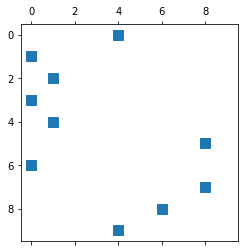

In [76]:
np.random.seed(10)
W1 = network1(N)
Y1 = dgp(k,N,T,rho0,beta0,gamma0,W1,alpha0,alpha1,X,Err)
print(np.shape(Y1))
plt.spy(W1)
para_W = W1.toarray()
# print(para_W)
para_WW = remove_diag(para_W)
# print(para_WW)
para_true = np.zeros(N*(N-2)+3)
para_true[-3:]=[rho0,gamma0,beta0]
para_true[:-3] = np.reshape(para_WW,(N*(N-2)))
# print(para_true)

In [77]:
print(para_true)
# para_initial = para_true.copy()
para_initial = np.ones(len(para_true))*0.1
para_initial[-3:]=np.array([0,0,0])
# para_initial = np.zeros(len(para_true))
print(para_initial)

[0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  0.  0.  1.  0.  0.  0.  0.3 0.5 0.4]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0. ]


In [78]:
maxiter=300
p1=1
p2=1
p3=0.01

res_gmm = minimize(mle,x0= para_initial,args=(Y1,X,p1,p2,p3), method='BFGS',options={'disp': True, 'maxiter': 1000})
# res_gmm_pen = minimize(gmm_pen,x0= para_initial,args=(Y1,X,p1,p2,p3), method='BFGS',options={'disp': True})
# res_mle = minimize(mle,x0= para_initial,args=(Y1,X), method='BFGS',options={'disp': True})
print(LA.norm(para_true-res_gmm.x))
# print(LA.norm(para_true-res_gmm_pen.x))
# print(LA.norm(para_true-res_mle.x))
print(res_gmm.x)
# print(res_mle.x)



# para_unp = res_mle.x
# test_para, test_error = LQA(X,Y1,0.01)
# print(test_para)
# print(para_unp)

Optimization terminated successfully.
         Current function value: 13.152398
         Iterations: 40
         Function evaluations: 3696
         Gradient evaluations: 44
1.7160297280191719
[-2.76534880e-01  3.04641823e-01  8.39616878e-01 -2.55896945e-01
  1.40917452e-02  1.24959129e-01  2.29829041e-01 -7.11584327e-02
  8.66137561e-01  1.41787326e-01 -2.01423986e-01  1.10186554e-01
  1.20086246e-01 -1.71013356e-01 -1.29637990e-01  7.39955181e-02
 -2.01173461e-01  1.09193350e+00 -1.58908333e-02 -1.37755370e-02
  2.38612485e-01  2.13264477e-01 -3.51096557e-01  6.84183918e-06
  9.36947395e-01  5.29500426e-01 -1.14311444e-01 -1.56622389e-01
  1.54531727e-01 -3.34019861e-01  4.96247844e-02  2.13219960e-01
  1.84116728e-01  1.23756549e+00 -4.18103107e-01 -1.60317915e-01
  8.87157862e-02  1.09498158e-01 -2.10036984e-01  1.63367758e-01
  1.19778767e-01 -6.13917835e-02 -3.51895368e-02 -1.03885948e-01
  2.53442021e-01 -1.52974518e-01  9.35802887e-01  6.17959293e-02
  7.95970000e-01  3.095959

In [79]:
tol = 1e-3

In [80]:
test_para = res_gmm.x
test_para[np.abs(test_para)<tol]=0
# print(test_para)
rWlist = test_para[0:-3]
tWlist = para_true[0:-3]
TPR_un = cal_TPR(rWlist,tWlist)
TNR_un = cal_TNP(rWlist,tWlist)
MSE_unconstrained = cal_MSE(test_para,Y1)
print('TPR is: ', TPR_un)
print('TNR is: ', TNR_un)
# print('Sum of squared bias is', MSE_unconstrained)
print('MSE is: ',MSE_unconstrained)

# rW = reconstruct(rWlist)
# print(rW)


TPR is:  1.0
TNR is:  0.014084507042253521
MSE is:  0.27287917224939257


In [81]:
# import seaborn as sns; 
# sns.set_theme()
# ax1 = sns.heatmap(rW.A, cmap="YlGnBu")
# # ax2 = sns.heatmap(W1.A, cmap="YlGnBu")
# plt.title('Unregularized')

## 4.2 Constrained optimization

In [87]:
#define boundaries 
from scipy.optimize import Bounds
lower = np.zeros(len(para_true))
lower[-1] = -1
lower[-2] = -1
# print(lower)
upper = np.ones(len(para_true))
# print(upper)
bounds = Bounds(lower,upper)
print(bounds)

Bounds(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1., -1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))


In [83]:
#define constraints 
# def cons3a(para,*args):
# 	Y, X,p1,p2,p3 = args
#     Wlist = para[0:-3]
# 	W = reconstruct(Wlist)
    
# 	return
p1=0.5
p2=0.5
p3=0.01

In [88]:
def gmm_lasso(para,*args):
	return (1+p2/T)*(gmm(para,*args)+ lasso_s3(para,*args))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2696.1410307408187
            Iterations: 123
            Function evaluations: 10245
            Gradient evaluations: 119
  (0, 1)	-0.6173498008575138
  (0, 2)	1.3798235342389415e-09
  (0, 3)	0.6799067553202098
  (0, 4)	0.09990636982728028
  (0, 5)	1.669593320631221e-09
  (0, 6)	2.829501070137997e-10
  (0, 7)	1.9960723341359146e-09
  (0, 8)	0.0947422001119749
  (0, 9)	0.7427944702696094
  (1, 0)	1.5286926855057437e-09
  (1, 2)	-0.2577642011203225
  (1, 3)	0.8735627164182755
  (1, 4)	5.002646155072506e-10
  (1, 5)	2.6712202283129426e-09
  (1, 6)	7.75748603954951e-11
  (1, 7)	0.1703518778530928
  (1, 8)	0.032161855252639204
  (1, 9)	0.1816877468185624
  (2, 0)	2.735456335045532e-09
  (2, 1)	5.523315780493217e-10
  (2, 3)	-0.060222151361170484
  (2, 4)	0.8723517731363243
  (2, 5)	1.6203825881310294e-09
  (2, 6)	1.557179900278545e-09
  (2, 7)	0.08216316045340902
  :	:
  (7, 2)	3.3824841997361556e-0

Text(0.5, 1.0, 'LASSO')

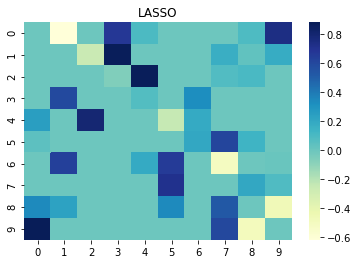

In [89]:
res_gmm_lasso = minimize(gmm_lasso ,x0= para_initial,args=(Y1,X,p1,p2,p3), method='SLSQP',options={'ftol': 1e-9, 'disp': True, 'maxiter': 1000}, bounds =bounds)
# print(LA.norm(para_true-res_gmm_lasso.x))
# print(res_gmm_lasso.x)
para_lasso = res_gmm_lasso.x
# print(para_lasso[-3:])
rWlist_lasso = para_lasso[0:-3]
rW_lasso = reconstruct(rWlist_lasso)
print(rW_lasso)
ax = sns.heatmap(rW_lasso.A, cmap="YlGnBu")
plt.title('LASSO')

In [ ]:
rW_original = reconstruct()

Text(0.5, 1.0, 'LASSO')

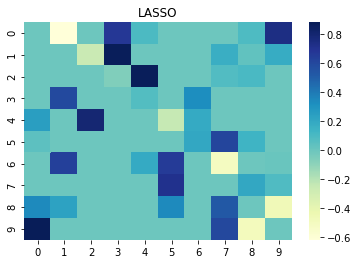

In [90]:
para_lasso[np.abs(para_lasso)<tol]=0
rWlist_lasso = para_lasso[0:-3]
rW_lasso = reconstruct(rWlist_lasso)
# print(rW_lasso)
ax = sns.heatmap(rW_lasso.A, cmap="YlGnBu")
plt.title('LASSO')

In [64]:
gmm_lasso_paras  = res_gmm_lasso.x
gmm_lasso_paras[np.abs(gmm_lasso_paras)<tol]=0
rWlist_gmm_lasso= gmm_lasso_paras[0:-3]
# tWlist = para_true[0:-3]
TPR_gmm_lasso = cal_TPR(rWlist_gmm_lasso,tWlist)
TNR_gmm_lasso = cal_TNP(rWlist_gmm_lasso,tWlist)
Bias_gmm_lasso = cal_Bias2(gmm_lasso_paras,para_true)
MSE_gmm_lasso = cal_MSE(gmm_lasso_paras,Y1)
print('TPR is: ', TPR_gmm_lasso)
print('TNR is: ', TNR_gmm_lasso)
print('MSE is: ', MSE_gmm_lasso)
print('rho is:', gmm_lasso_paras[-3])
print('gamma is:', gmm_lasso_paras[-2])
print('beta is:', gmm_lasso_paras[-1])
# print(np.count_nonzero(rWlist_gmm_lasso))
print(np.sum(rW_lasso,axis=1))

TPR is:  0.2222222222222222
TNR is:  0.5915492957746479
MSE is:  2375822011062644.5
rho is: 0.9999999927107559
gamma is: -0.37846470365570056
beta is: 0.3687149134521167
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


## Elastic Net 

In [65]:
res_gmm_pen = minimize(gmm_pen ,x0= para_initial,args=(Y1,X,p1,p2,p3), method='SLSQP',options={'ftol': 1e-9, 'disp': True, 'maxiter': 1000}, bounds =bounds)
print(LA.norm(para_true-res_gmm_pen.x))
print(res_gmm_pen.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2696.2773824542737
            Iterations: 129
            Function evaluations: 10788
            Gradient evaluations: 125
4.138494350985195
[ 1.38509523e-05  6.79721186e-01  9.99695713e-02  8.76870361e-09
  1.42753264e-04  1.04806033e-08  9.46439587e-02  7.42725863e-01
  8.03323788e-09  8.73366734e-01  1.17153522e-04  1.40127309e-08
  1.86763085e-04  1.70188874e-01  3.22824984e-02  1.81547383e-01
  1.43559122e-08  2.89726608e-09  8.72304124e-01  7.79289834e-07
  8.17210342e-09  8.23356849e-02  1.05525554e-01  1.26630228e-08
  2.95270034e-08  5.98032705e-01  7.98419601e-09  5.09087380e-08
  3.27713178e-01  7.46797633e-08  4.11405320e-08  6.76960709e-08
  2.49880374e-01  1.06129046e-08  7.96515587e-01  8.65895409e-05
  1.93695250e-01  8.70080360e-09  1.26101772e-08  1.97830762e-05
  4.56501593e-02  1.96728759e-08  1.40771898e-08  1.10980146e-08
  9.68953317e-09  6.13008822e-01  1.39603271e-01  8.

In [66]:
gmm_pen_paras  = res_gmm_pen.x
gmm_pen_paras[np.abs(gmm_pen_paras)<tol]=0
rWlist_gmm_pen= gmm_pen_paras[0:-3]
# tWlist = para_true[0:-3]
TPR_gmm_pen = cal_TPR(rWlist_gmm_pen,tWlist)
TNR_gmm_pen = cal_TNP(rWlist_gmm_pen,tWlist)
MSE_gmm_pen = cal_MSE(gmm_pen_paras,para_true)
print('TPR is: ', TPR_gmm_pen)
print('TNR is: ', TNR_gmm_pen)
print('MSE is: ', MSE_gmm_pen)

ValueError: operands could not be broadcast together with shapes (50,10) (83,) 

# PSW

In [ ]:
 pip install pyswarms

In [ ]:
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

In [ ]:
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options)
cost, pos = optimizer.optimize(fx.sphere, iters=1000)

In [ ]:
from pyswarms.single.global_best import GlobalBestPSO

In [243]:
def gmm_pso(para,Y,X,p1,p2,p3):
#     Y, X,p1,p2,p3 = args
    para = np.reshape(para,(N*(N-2)+3))
    rho = para[-3]
    gamma = para[-2]
    beta = para[-1]
    Wlist = para[0:-3]
#     W = W1
    W = reconstruct(Wlist)
    ERR = (eye-rho*W)@np.transpose(Y)-(beta*eye+gamma*W)@np.transpose(X)
    ERR = np.transpose(ERR)
    gnt = np.zeros(N*N)
    for j in range(T):
        temp = np.outer(X[j],ERR[j])
        gnt = gnt+temp.reshape((N*N))

  #weight matrix 
    Weight = np.identity(N*N)
    gnt.reshape((N*N,1))
    return np.transpose(gnt)@Weight@gnt


#def unpenalized mle   
#assume the little sigma =1 
def mle_pso(para,Y,X,p1,p2,p3):
#     Y, X,p1,p2,p3 = args
    para = np.reshape(para,(N*(N-1)+3))
    rho = para[-3]
    gamma = para[-2]
    beta = para[-1]
    Wlist = para[0:-3]
    W = reconstruct(Wlist)

    ERR = (eye-rho*W)@np.transpose(Y)-(beta*eye+gamma*W)@np.transpose(X)
    ERR = np.transpose(ERR)
    tllk=0
    for i in range(T):
        error = np.reshape(ERR[i],(N,1))
        tllk = tllk-0.5*N*math.log(2*math.pi)-0.5*np.transpose(error)@error
  
    llk = tllk/T

    return -llk.item()
  
#define the penalty functions
def lasso_s1_pso(para,Y,X,p1,p2,p3):
#     Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + (abs(Wlist[i]))
    return p1*lasso_pen

def lasso_s2_pso(para,Y,X,p1,p2,p3):
#     Y, X,p1,p2,p3= args
    Wlist = para[0:-3]
    lasso_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + (abs(Wlist[i]))
    return p2*lasso_pen


def lasso_s3_pso(para,Y,X,p1,p2,p3):
#     Y, X,p1,p2,p3= args
    Wlist = para[0:-3]
    lasso_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + (Wlist[i])
    return p2*lasso_pen



def elsn_s1_pso(para,Y,X,p1,p2,p3):
#     Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + p1*(abs(Wlist[i]))
        ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
        return ridge_pen+lasso_pen


def elsn_s2_pso(para,Y,X,p1,p2,p3):
#     Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
    	lasso_pen = lasso_pen + p2*(abs(Wlist[i]))
    	ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
    return ridge_pen+lasso_pen


def elsn_s3_pso(para,Y,X,p1,p2,p3):
#     Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + p1*(Wlist[i])
        ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
    
    return ridge_pen+lasso_pen
  
  
  
def gmm_pen_pso(para,Y,X,p1,p2,p3):
	return (1+p2/T)*(gmm(para,*args)+ elsn_s3(para,*args))

def gmm_lasso_pso(para,Y,X,p1,p2,p3):
	return (1+p2/T)*(gmm(para,*args)+ lasso_s3(para,*args))
